In [1]:
import numpy as np
import torch
import torch.nn.functional as F

from torch.nn import Linear
from torch.utils.data import DataLoader, TensorDataset

from functools import partial
from matplotlib import pyplot as plt

from lafomo.datasets import ToyTimeSeries, ToySpatialTranscriptomics
from lafomo.models import OperatorModel
from lafomo.nn import LpLoss

(453870, 4)
270
(1681, 4)


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


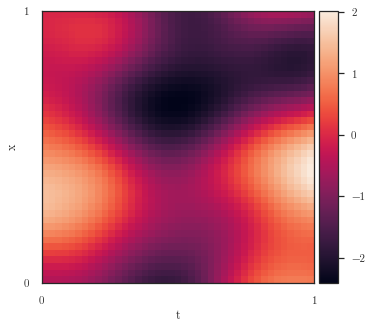

In [55]:
from lafomo.utilities.torch import get_image
from lafomo.plot import Plotter, plot_spatiotemporal_data

dataset = ToySpatialTranscriptomics('../../data', one_fixed_sample=False)
print(len(dataset))
i = 49
orig_data = dataset.orig_data[1681*(i):1681*(i+1)]
print(orig_data.shape)
images = [get_image(orig_data, i) for i in range(2, 4)]
tx = dataset.data[0][0]
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]

ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [torch.tensor(orig_data[:, 2]).view(num_t, num_x).t()],
    extent, nrows=1, ncols=1
)
block_dim = 2

ntest = 50
ntrain = len(dataset) - ntest
batch_size = 50
learning_rate = 0.001

step_size = 100
gamma = 0.5

modes = 12
width = 32
def generate_neural_dataset(dataset, ntrain, ntest):
    s = 41
    tx, _ = dataset.data[0]
    grid = tx.t()
    grid = torch.tensor(grid.reshape(1,s,s,2), dtype=torch.float)

    data = torch.tensor(dataset.orig_data.reshape(len(dataset), s, s, 4), dtype=torch.float)
    y_train = data[:ntrain, ..., 2:3]
    x_train = data[:ntrain, ..., 3]
    y_test = data[ntrain:, ..., 2:3]
    x_test = data[ntrain:, ..., 3]

    x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
    x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

    train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                              batch_size=batch_size, shuffle=True)
    if ntest > 0:
        test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                              batch_size=ntest, shuffle=True)
        return train_loader, test_loader
    else:
        return train_loader

train_loader, test_loader = generate_neural_dataset(dataset, ntrain, ntest)

In [20]:
num_outputs = 10
basal_rate = 0.1 + 0.3 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
sensitivity = 2 + 5 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
decay_rate = 0.2 + 2 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)


In [3]:
ntrain = 15
ntest = 5
learning_rate = 1e-3
batch_size = ntrain

datasets = list()
for i in range(ntrain + ntest):
    dataset = ToyTimeSeries(num_outputs, 1, 10, params=[basal_rate, sensitivity, decay_rate], plot=False)
    datasets.append(dataset)

In [14]:
x_train = torch.cat([dataset.m_observed for dataset in datasets[:ntrain]]).permute(0, 2, 1)
x_test = torch.cat([dataset.m_observed for dataset in datasets[ntrain:]]).permute(0, 2, 1)
T_in = 11
grid = datasets[0].t_observed.reshape(1, -1, 1).repeat(ntrain, 1, 1) # (1, 32, 32, 40, 1)
grid_test = datasets[0].t_observed.reshape(1, -1, 1).repeat(ntest, 1, 1) # (1, 32, 32, 40, 1)

x_train = torch.cat([grid, x_train], dim=-1)
x_test = torch.cat([grid_test, x_test], dim=-1)
y_train = torch.cat([dataset.f_observed for dataset in datasets[:ntrain]]).permute(0, 2, 1)
y_test = torch.cat([dataset.f_observed for dataset in datasets[ntrain:]]).permute(0, 2, 1)
print('y', y_train.shape)
print('x', x_train.shape)

train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                          batch_size=ntest, shuffle=True)




NameError: name 'datasets' is not defined

In [7]:
width = 20
modes = 4
model = OperatorModel(block_dim, modes, width)
print(model.count_params())

55777


In [8]:
gamma = 0.5
step_size = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = LpLoss(size_average=False)

In [37]:
epochs = 50

for ep in range(epochs):
    model.train()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        # x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    test_mse = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            # x, y = x.cuda(), y.cuda()

            out = model(x)
            test_mse += F.mse_loss(out, y, reduction='mean')
            test_l2 += myloss(
                out.view(test_loader.batch_size, -1), y.view(test_loader.batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    test_mse /= ntest

    print(f'Epoch {ep}/{epochs}: MSE (train/test): {train_mse:.03f} {test_mse:.03f} L2 (train/test): {train_l2:.03f}, {test_l2:.03f}')

Epoch 0/50: MSE (train/test): 0.233 0.012 L2 (train/test): 0.476, 0.504
Epoch 1/50: MSE (train/test): 0.232 0.011 L2 (train/test): 0.474, 0.504
Epoch 2/50: MSE (train/test): 0.229 0.011 L2 (train/test): 0.472, 0.499
Epoch 3/50: MSE (train/test): 0.228 0.011 L2 (train/test): 0.470, 0.499
Epoch 4/50: MSE (train/test): 0.225 0.011 L2 (train/test): 0.467, 0.498
Epoch 5/50: MSE (train/test): 0.223 0.011 L2 (train/test): 0.466, 0.496
Epoch 6/50: MSE (train/test): 0.222 0.011 L2 (train/test): 0.464, 0.490
Epoch 7/50: MSE (train/test): 0.220 0.011 L2 (train/test): 0.462, 0.492
Epoch 8/50: MSE (train/test): 0.218 0.011 L2 (train/test): 0.460, 0.488
Epoch 9/50: MSE (train/test): 0.218 0.011 L2 (train/test): 0.460, 0.488
Epoch 10/50: MSE (train/test): 0.216 0.011 L2 (train/test): 0.458, 0.484
Epoch 11/50: MSE (train/test): 0.214 0.011 L2 (train/test): 0.456, 0.485
Epoch 12/50: MSE (train/test): 0.213 0.010 L2 (train/test): 0.454, 0.483
Epoch 13/50: MSE (train/test): 0.211 0.010 L2 (train/test): 0

In [63]:
def show_result(x, y, out):
    if block_dim == 1:
        fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
        for i in range(1, 5):
            axes[0].plot(x[0, :, i])#.shape, y.shape)
        axes[1].plot(y[0, :, 0])
        axes[1].plot(out[0, :, 0].detach())
    else:
        plot_spatiotemporal_data(
            [
                out[0, ..., 0].detach().view(num_t, num_x).t(),
                y[0, ..., 0].view(num_t, num_x).t(),
                x[0, ..., 0].view(num_t, num_x).t()
            ],
            extent, nrows=1, ncols=3,
            titles=['Latent (Prediction)', 'Latent (Target)', 'Output (Target)']
        )

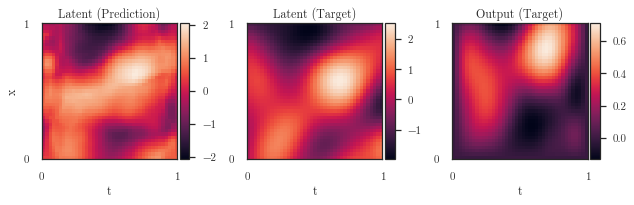

In [65]:
x, y = next(iter(test_loader))
out = model(x)
show_result(x, y, out)

(1681, 4)
torch.Size([1, 41, 41, 3]) torch.Size([1, 41, 41, 1])
torch.Size([1, 41, 41, 3])


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


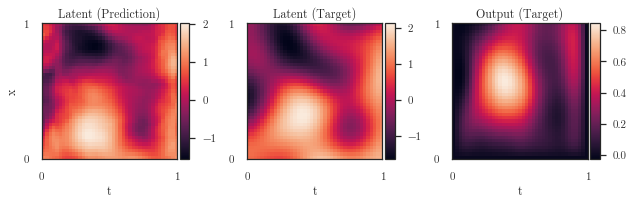

In [62]:
dataset = ToySpatialTranscriptomics('../../data', one_fixed_sample=True)
train_loader = generate_neural_dataset(dataset, 1, 0)
x, y = next(iter(train_loader))
out = model(x)
show_result(x, y, out)

In [ ]:
path = '../../data/ns_V1e-3_N5000_T50.mat'
from h5py import File

# u shape (50, 64, 64, 5000)
# a shape (64, 64, 5000)
# t shape (50, 1)

f = File(path)
print(f)
print(f['u'])

modes = 4
width = 20

batch_size = 10
batch_size2 = batch_size

epochs = 10
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)


runtime = np.zeros(2, )

ntrain = 100
sub = 1
S = 64 // sub
T_in = 10
T = 40
S = 32

# train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
# train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]
train_a = torch.rand((100, 32, 32, 50))[:, :, :, :T_in]
train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
print(train_a.shape)
# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
# 32
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
# 1, 32, 32, 40, 1 (1, S, S, T, 1)
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])
# (1, S, S, T, 1)
print(gridt.shape, gridx.shape)
# for t in range(10):
#     plt.figure()
#     plt.imshow(gridy.squeeze()[:, :, t])
print(gridx.repeat([ntrain,1,1,1,1]).shape)
train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
print(train_a.shape)

torch.Size([100, 32, 32, 40, 13])


In [ ]:
# This part checks our complex multiplication code:
def compl_mul1d(a, b):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    op = partial(torch.einsum, "bix,iox->box")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

weights1_sep = torch.rand(20, 20, 4, 2)
weights1_sep = torch.rand(64, 64, 4, 2)
weights1 = weights1_sep[:, :, :, 0] + weights1_sep[:, :, :, 1] * 1j
x = torch.randn((15, 20, 11))
x = torch.randn((100, 64, 1024))
print(x.shape)

In [ ]:
x_ft = torch.fft.rfft(x)
x_ft_sep = torch.stack([
    torch.real(x_ft),
    torch.imag(x_ft)
    ], dim=-1)
print(x_ft_sep.shape)

In [ ]:
mul2 = compl_mul1d(x_ft_sep[:, :, :4], weights1_sep)
print(mul2)

In [ ]:
op = partial(torch.einsum, "bix,iox->box")
    # return torch.stack([
    #     op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
    #     op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    # ], dim=-1)

A = x_ft[:, :, :4]#.unsqueeze(1)
B = weights1#.unsqueeze(0)
print(A.shape, B.shape)
print(A.type())
# print(B.type(torch.complex64))
mul = op(A, B.type(torch.complex64))
# mul = torch.matmul(A, B)
print(mul.shape, mul2.shape)

print(mul2[where])



In [ ]:
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

grid = np.linspace(0, 2*np.pi, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.randn(ntrain, s, 1)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)

modes = 16
width = 64
print(x_train.shape)
x = Linear(2, width)(x_train).permute(0, 2, 1)
print(x.shape)